In [0]:
import pandas as pd
import numpy as np
import sklearn as skl
import sklearn.preprocessing as pre
import matplotlib.pyplot as plt
import statsmodels as sm
import sklearn.linear_model as lm
from sklearn.metrics import roc_auc_score
import sklearn.metrics
import sklearn.model_selection
from datetime import datetime

training = pd.read_csv('glm.training.data.csv')
test = pd.read_csv('glm.test.data.csv')
test_times = pd.read_csv('timestamps.test.csv')
onset = pd.read_csv('test.onsets.csv')

##Process data

In [0]:
# Training data preprocessing
training_y = np.asarray(training[['y']])
training_x = training.drop(['y', 'Unnamed: 0'], axis = 1)
training_x_norm = pre.normalize(training_x)

# Testing data preprocessing
test_y = np.asarray(test[['y']])
test_x = test.drop(['y', 'Unnamed: 0', 'patient'], axis = 1)
test_x_norm = pre.normalize(test_x)

# Patient and temporal data processing
patient = np.asarray(test[['patient']])
test_time = np.asarray(test_times.drop(['Unnamed: 0'], axis = 1))

print(training_x.head(4)) 

        x.hr       x.sbp      x.dbp  ...  x.liver.sofa  x.coag.sofa  x.kidney.sofa
0  87.252031  119.411786  61.039926  ...             0            0              0
1  87.252031  119.411786  61.039926  ...             0            0              0
2  87.252031  119.411786  61.039926  ...             0            0              0
3  87.252031  119.411786  61.039926  ...             0            0              0

[4 rows x 28 columns]


In [0]:
# Run with default penalty (C = 1) and see what the coefficients look like
train_fit = lm.LogisticRegression(penalty = 'l1', solver = 'saga', max_iter=500).fit(training_x_norm, np.asarray(training_y).ravel())
# We can see from this we need to find a better penalty to avoid overfitting, as
# all 28 features are weighted. 
print(train_fit.coef_)

#Now we shift to using stochastic gradient decent to optimize run time. 

##Use a subset of the data to predict an optimal range of penalties

In [0]:
# Shuffle the data so we can sample it with better confidence
training_x_norm, training_y = skl.utils.shuffle(training_x_norm, training_y)
training_y = np.asarray(training_y)
training_fraction = 0.2

# Create a subset of the data so we can test penalty values.
sample = skl.utils.random.sample_without_replacement(training_x_norm.shape[0], int(len(training_x_norm) * training_fraction))

smol_train_x = training_x_norm[sample]
smol_train_y = training_y[sample]
smol_train_y = np.asarray(smol_train_y)

# Note that because we are only taking a portion of the sample, we have to scale our
# lambda value by that same proportion. 
lr = lm.SGDClassifier(loss='log', penalty = 'l1', alpha = 0.000005)
print(lr.fit(smol_train_x, smol_train_y.ravel()).coef_)

# From this we can see that a ballpark optimal range for the full
# data set should be from around 0.01 to 0.05 for logistic regression
# or somewhere between 1e-07 and 1e-08 for SGD.

[[   9.60541493  -15.57142825    1.38684366    2.16190206   20.13535595
     0.            1.29268746    2.81280224    7.50090365  -96.19819548
     1.88071459   -0.17269923   50.74083418  114.24873626    4.28401431
    -1.76954314   12.02325541   -6.38016807   27.94865257    1.04909863
    39.38080088   -0.92848931    0.70025515 -119.5554265    97.75569795
     0.            0.          -25.27710541]]


##Find optimal penalty value

In [0]:
# Do cross validation with 10 folds and compute the scores on each iteration
# save average scores among all 10 folds in a dict with the cooresponding alpha value
score = {}
count = 0
for c in np.linspace(7.5e-07,9.5e-07, 10):
  model = lm.SGDClassifier(loss='log', penalty= 'l1', alpha=c)
  score[c] = np.mean(skl.model_selection.cross_val_score(model, training_x_norm, training_y.ravel(), cv = 10))
  count += 1
  print(count/10)

Optimal alpha value: 7.722222222222222e-07


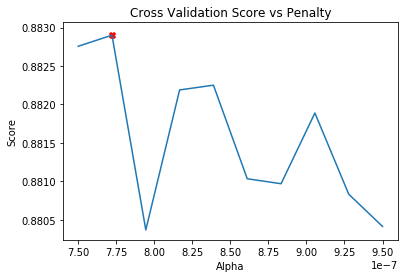

In [0]:
# Find the minimum score and use thos alpha value
plt.plot(score.keys(), score.values())
plt.title('Cross Validation Score vs Penalty')
plt.xlabel('Alpha')
plt.ylabel('Score')
maxval = max(list(score.values()))
alpha_best = list(score.keys())[list(score.values()).index(maxval)]
print('Optimal alpha value:', alpha_best)
plt.scatter(alpha_best, maxval, marker='X', c='red')

In [0]:
# Use a SGD classifier as a stochastic optimizer to do logistic regression quickly
# Gives the same results after adjusting the alpha value

sgd = lm.SGDClassifier(loss='log', penalty= 'l1', alpha=alpha_best).fit(training_x_norm, np.asarray(training_y).ravel())
print(sgd.coef_)
sgd_prob = sgd.predict_proba(test_x_norm)[:, 1]
sgd_training_prob = sgd.predict_proba(training_x_norm)[:, 1]

[[ 1.11916075e+01 -1.70401672e+01  1.24631438e+00  7.06554906e-01
   2.32071914e+01  8.57188857e+00  1.87622849e+00  2.47124233e+00
   9.18004841e+00 -2.17415747e+02 -5.72074680e+00  1.15869268e-01
   1.47454916e+01  3.10669921e+02  6.55932112e+00 -9.88246379e+00
   9.41760917e+00 -4.41797585e+00  6.05143712e+01 -1.67913804e+00
   9.70862646e+01  4.02395296e-02  6.56462847e+01 -4.40228796e+02
   5.29517838e+02  4.88351096e+01  2.90985601e+01 -4.43793867e+01]]


In [0]:
train_fit = lm.LogisticRegression(solver = 'saga', penalty= 'l1', C=0.2, max_iter=500).fit(training_x_norm, np.asarray(training_y).ravel())
print(train_fit.coef_)
logit_prob = train_fit.predict_proba(test_x_norm)[:, 1]
logit_prob = train_fit.predict_proba(training_x_norm)[:, 1]
# Get pretty much the same results using this but it takes way longer, so we opt to use SGD

[[ 1.22504057e+01 -1.47065913e+01  1.87325332e+00  2.04888175e-01
   2.19590729e+01  1.74822328e+00  1.39947043e+00  2.31666561e+00
   9.11027397e+00 -2.04939305e+02  1.47864474e+00  1.25442592e-01
   1.39727450e+01  2.31911430e+02  4.68803855e+00  0.00000000e+00
   9.22397591e+00 -3.27626485e+00  2.92804811e+01  0.00000000e+00
   2.74711596e+01 -1.38691532e-02  0.00000000e+00 -4.30537399e+02
   9.92123739e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


##Find optimal threshold

Optimal Threshold: 0.130


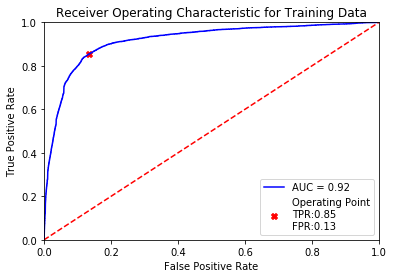

In [0]:
fpr, tpr, threshold = skl.metrics.roc_curve(training_y, sgd_training_prob)
roc_auc = skl.metrics.auc(fpr, tpr)
left = np.asarray([0,1])
norm = 1
for i in range(len(fpr)):
  curve = np.asarray([fpr[i], tpr[i]])
  dist = np.linalg.norm(left-curve)
  if dist < norm:
    norm = dist
    x = fpr[i]
    y = tpr[i]
    thresh = threshold[i]

print("Optimal Threshold: %0.3f" % thresh)
plt.title('Receiver Operating Characteristic for Training Data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.scatter(x, y, c = 'r', marker='X', label='Operating Point\nTPR:%0.2f\nFPR:%0.2f' % (y, x))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Apply to held-out data


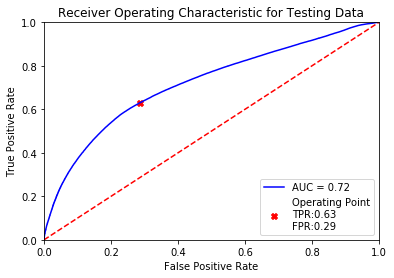

In [0]:
fpr, tpr, threshold = skl.metrics.roc_curve(test_y, sgd_prob)
roc_auc = skl.metrics.auc(fpr, tpr)
left = np.asarray([0,1])
norm = 1
for i in range(len(fpr)):
  curve = np.asarray([fpr[i], tpr[i]])
  dist = np.linalg.norm(left-curve)
  if dist < norm:
    norm = dist
    x = fpr[i]
    y = tpr[i]

plt.title('Receiver Operating Characteristic for Testing Data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.scatter(x, y, c = 'r', marker='X', label='Operating Point\nTPR:%0.2f\nFPR:%0.2f' % (y, x))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
metrics = skl.metrics.classification_report(test_y, sgd.predict(test_x_norm))
print(metrics)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95   1186680
           1       0.38      0.13      0.19    115698

    accuracy                           0.90   1302378
   macro avg       0.65      0.55      0.57   1302378
weighted avg       0.87      0.90      0.88   1302378



In [0]:
test_predict = []
for i in sgd_prob:
  if i >= thresh:
    test_predict.append(1)
  else:
    test_predict.append(0)
print(sum(test_predict))

245555


In [0]:
# Create a list of all the onset times, probably could have used the ones in the file
# given but this works too
onset = []
indecies = []
# Patients from 5624 to 6737 went into shock in the test data so we go through this
for i in range(5624, 6738):
  index = np.max(np.argwhere(np.asarray(patient) == i))
  indecies.append(index)
  onset.append(test_time[index])
onset = np.asarray(onset).reshape(-1)
print(onset[6])

2197-12-06 11:15:00


In [0]:
# Find the earliest instance of a positive shock prediction for eacy true positive patient in the sample
# If shock was not correctly preedicted for a patient that went into shock, a 0 is given. 
early = []
for i in indecies:
  if test_predict[i] != 1:
    early.append(0)
    continue
  j = i
  while test_predict[j] == 1 and patient[j] == patient[j - 1]:
    j -= 1
  early.append(test_time[j + 1, 0]) 

early = np.asarray(early)
print(early[6])

2197-12-06 11:15:00


In [0]:
# Time for some magic datetime stuff to calculate prediction time. Wil have prediction time in hours.
FMT = '%Y-%m-%d %H:%M:%S'
ewt = []
for i in range(len(onset)):
  if early[i] != '0':
    delta = datetime.strptime(onset[i], FMT) - datetime.strptime(early[i], FMT)
    ewt.append(delta.total_seconds() / 3600)
  else:
    ewt.append(0)
print(ewt)

[1.0, 4.6, 0.0, 2.1, 0, 2.8, 0.0, 0.21666666666666667, 0.25, 0.6, 13.233333333333333, 0, 0.0, 2.0833333333333335, 0.8333333333333334, 5.316666666666666, 0, 1.85, 2.5833333333333335, 0.2833333333333333, 6.166666666666667, 0, 0, 9.116666666666667, 1.9833333333333334, 13.5, 25.466666666666665, 185.36666666666667, 5.216666666666667, 0.0, 1.1666666666666667, 1.1333333333333333, 9.083333333333334, 19.6, 13.516666666666667, 0.0, 14.666666666666666, 8.15, 0.25, 16.95, 2.75, 1.0666666666666667, 0, 2.716666666666667, 0.4666666666666667, 63.25, 15.95, 0.23333333333333334, 3.85, 5.966666666666667, 4.7, 159.08333333333334, 0, 0.9666666666666667, 1.05, 2.75, 0.5, 1.6666666666666667, 10.516666666666667, 5.05, 0, 5.0, 6.383333333333334, 14.55, 0, 0.43333333333333335, 20.083333333333332, 1.5, 1.7833333333333334, 20.5, 0.0, 1.6333333333333333, 3.5833333333333335, 0.0, 0.6333333333333333, 0.15, 13.15, 0.0, 6.75, 5.433333333333334, 0.18333333333333332, 0.5, 13.5, 0, 4.5, 1.35, 0.016666666666666666, 0.9833

Median Early Waring Time:  2.0 hours.
Mean Early Waring Time: 6.40 hours.


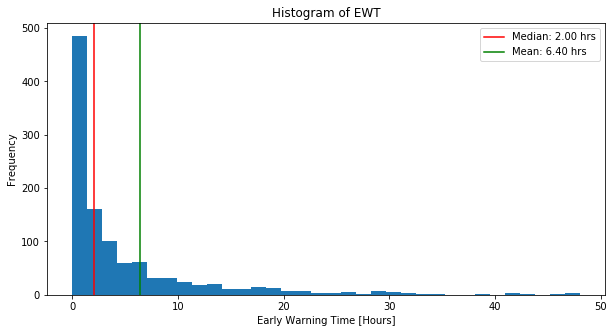

In [0]:
bins = np.linspace(0, 48, 35)
plt.figure(figsize=[10, 5])
groups = plt.hist(ewt, bins)
plt.axvline(np.median(ewt), color='r', label='Median: %0.2f hrs' % np.median(ewt))
plt.axvline(np.mean(ewt), color='g', label='Mean: %0.2f hrs' % np.mean(ewt))
plt.legend(loc = 'upper right')
plt.title('Histogram of EWT')
plt.ylabel('Frequency')
plt.xlabel('Early Warning Time [Hours]')
print("Median Early Waring Time: ", np.median(ewt), 'hours.')
print("Mean Early Waring Time: %0.2f hours." % np.mean(ewt))

#Now with data balancing

In [0]:
print('Percent of patients that went into shock: %0.2f' % (np.sum(training_y) / len(training_y) * 100) + ' %')
# We can see that only about 17% of the patients in the data-set went into septic shock
# which is a pretty low proportion of the data. To try to balance this, we use some oversampling.

Percent of patients that went into shock: 16.53 %


In [0]:
minority = training_x_norm[np.argwhere(training_y.reshape(-1) == 1)]
num = training_y.reshape(-1).shape[0] - minority.shape[0] 
minority = minority.reshape(minority.shape[0], 28)
# Upsample the minority data to match the numper of smaples in the majority. 
minority = skl.utils.resample(minority, replace = True, n_samples = num)
majority = training_x_norm[np.argwhere(training_y.reshape(-1) == 0)]
majority = majority.reshape(majority.shape[0], 28)

training_upsample_x = np.concatenate([majority, minority])
training_upsample_y = np.zeros(training_upsample_x.shape[0])
training_upsample_y[int(training_upsample_x.shape[0] / 2): training_upsample_x.shape[0]] = 1
print(training_upsample_x.shape)

(2631400, 28)


In [0]:
# Now repeat the above calculations using the upsampled data
sgd = lm.SGDClassifier(loss='log', penalty= 'l1', alpha=alpha_best).fit(training_upsample_x, training_upsample_y)
print(sgd.coef_)
sgd_prob = sgd.predict_proba(test_x_norm)[:, 1]
sgd_training_prob = sgd.predict_proba(training_upsample_x)[:, 1]

[[  13.66678885  -21.59664774   -2.99182907    5.03938833   30.65507424
     6.73866952    1.85066101    2.44933292    9.94963499 -259.87279651
    -7.8060616     0.           11.04522312  466.68661472    7.34332535
   -18.80106847   16.47795394   -5.67030894   62.16133227   -5.65963185
   158.8620419     0.          119.77975131 -528.62902063  787.26864522
    74.08624972   63.6429777   -40.85289106]]


##Find optimal threshold

Optimal Threshold: 0.408


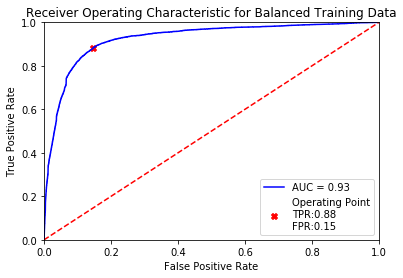

In [0]:
fpr, tpr, threshold = skl.metrics.roc_curve(training_upsample_y, sgd_training_prob)
roc_auc = skl.metrics.auc(fpr, tpr)
left = np.asarray([0,1])
norm = 1
for i in range(len(fpr)):
  curve = np.asarray([fpr[i], tpr[i]])
  dist = np.linalg.norm(left-curve)
  if dist < norm:
    norm = dist
    x = fpr[i]
    y = tpr[i]
    thresh = threshold[i]

print("Optimal Threshold: %0.3f" % thresh)
plt.title('Receiver Operating Characteristic for Balanced Training Data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.scatter(x, y, c = 'r', marker='X', label='Operating Point\nTPR:%0.2f\nFPR:%0.2f' % (y, x))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# AUC increases a little and threshold increase drastically here using upsampling

##Apply to held-out data

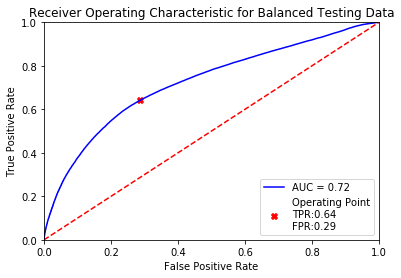

In [0]:
fpr, tpr, threshold = skl.metrics.roc_curve(test_y, sgd_prob)
roc_auc = skl.metrics.auc(fpr, tpr)
left = np.asarray([0,1])
norm = 1
for i in range(len(fpr)):
  curve = np.asarray([fpr[i], tpr[i]])
  dist = np.linalg.norm(left-curve)
  if dist < norm:
    norm = dist
    x = fpr[i]
    y = tpr[i]

plt.title('Receiver Operating Characteristic for Balanced Testing Data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.scatter(x, y, c = 'r', marker='X', label='Operating Point\nTPR:%0.2f\nFPR:%0.2f' % (y, x))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# Looks like the AUC here increases by a bit with balancing

In [0]:
metrics = skl.metrics.classification_report(test_y, sgd.predict(test_x_norm))
print(metrics)

              precision    recall  f1-score   support

           0       0.94      0.89      0.92   1186680
           1       0.26      0.39      0.31    115698

    accuracy                           0.85   1302378
   macro avg       0.60      0.64      0.61   1302378
weighted avg       0.88      0.85      0.86   1302378



In [0]:
test_predict = []
for i in sgd_prob:
  if i >= thresh:
    test_predict.append(1)
  else:
    test_predict.append(0)
print(sum(test_predict))

265572


##Compute and plot EWT

In [0]:
# Create a list of all the onset times, probably could have used the ones in the file
# given but this works too
onset = []
indecies = []
# Patients from 5624 to 6737 went into shock in the test data so we go through this
for i in range(5624, 6738):
  index = np.max(np.argwhere(np.asarray(patient) == i))
  indecies.append(index)
  onset.append(test_time[index])
onset = np.asarray(onset).reshape(-1)
print(onset[6])

2197-12-06 11:15:00


In [0]:
# Find the earliest instance of a positive shock prediction for eacy true positive patient in the sample
# If shock was not correctly predicted for a patient that went into shock, a 0 is given. 
early = []
for i in indecies:
  if test_predict[i] != 1:
    early.append(0)
    continue
  j = i
  while test_predict[j] == 1 and patient[j] == patient[j - 1]:
    j -= 1
  early.append(test_time[j + 1, 0]) 

early = np.asarray(early)
print(early[6])

2197-12-06 11:15:00


In [0]:
# Time for some magic datetime stuff to calculate prediction time. Wil have prediction time in hours.
FMT = '%Y-%m-%d %H:%M:%S'
ewt = []
for i in range(len(onset)):
  if early[i] != '0':
    delta = datetime.strptime(onset[i], FMT) - datetime.strptime(early[i], FMT)
    ewt.append(delta.total_seconds() / 3600)
  else:
    ewt.append(0)
print(ewt)

[1.0, 4.6, 0.0, 2.1, 0.0, 2.8, 0.0, 0.21666666666666667, 0.25, 0.6, 13.233333333333333, 0, 0.0, 2.0833333333333335, 0.8333333333333334, 5.316666666666666, 0, 1.85, 2.5833333333333335, 0.2833333333333333, 6.166666666666667, 0, 0, 9.116666666666667, 1.9833333333333334, 13.5, 25.466666666666665, 44.86666666666667, 5.216666666666667, 1.4666666666666666, 1.1666666666666667, 3.6666666666666665, 9.083333333333334, 19.6, 13.516666666666667, 0.0, 11.666666666666666, 16.05, 0.5, 16.95, 4.25, 1.0666666666666667, 0, 2.716666666666667, 0.4666666666666667, 63.25, 15.95, 0.23333333333333334, 3.85, 5.966666666666667, 4.7, 159.08333333333334, 0, 0.9666666666666667, 1.05, 2.75, 0.5, 1.6666666666666667, 10.516666666666667, 5.05, 0.0, 5.0, 6.383333333333334, 14.55, 18.5, 0.43333333333333335, 20.083333333333332, 2.8833333333333333, 6.45, 26.416666666666668, 0.0, 1.6333333333333333, 3.5833333333333335, 0.0, 0.6333333333333333, 0.15, 13.15, 0.0, 8.25, 5.433333333333334, 0.18333333333333332, 0.5, 13.5, 0, 4.5

Median Early Waring Time: 2.17  hours.
Mean Early Waring Time: 7.17 hours.


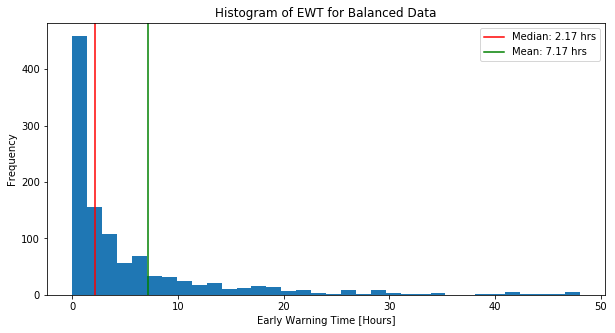

In [0]:
bins = np.linspace(0, 48, 35)
plt.figure(figsize=[10, 5])
groups = plt.hist(ewt, bins)
plt.axvline(np.median(ewt), color='r', label='Median: %0.2f hrs' % np.median(ewt))
plt.axvline(np.mean(ewt), color='g', label='Mean: %0.2f hrs' % np.mean(ewt))
plt.legend(loc = 'upper right')
plt.title('Histogram of EWT for Balanced Data')
plt.ylabel('Frequency')
plt.xlabel('Early Warning Time [Hours]')
print("Median Early Waring Time: %0.2f " % np.median(ewt), 'hours.')
print("Mean Early Waring Time: %0.2f hours." % np.mean(ewt))

In [0]:
# We can see using upsampling as a balancing technique that both the median and 
# mean early warning prediction time increase, but not by a ton. 